In [4]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef

In [5]:
# INPUT CELL

# load GPU
gpu_id = '3'

# name of the default simulation
sim_name = 'canon_g1_ola_new_psc'

# templates to build synthetic data (other option to do this below)
rig_temp_select = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_select = ['pib','ics', 'blg'] # pib, ics, blg
var_temp_select = ['nfw'] # nfw, dsk

In [6]:
# load GPU
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data and fits are stored
data_dir = ef.load_data_dir(sim_name)

# load fitting parameters used to define the synthetic data
import importlib
sys.path.append(data_dir)
module = importlib.import_module('sim_settings')
globals().update(vars(module)) # loads all variables from module

# load the svi results
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + str_svi_seed + '.p')

samples, svi_results = pickle.load(open(data_dir + file_name, 'rb'))

In [8]:
from models.poissonian_ed_amarel_customroi_new_psc import EbinPoissonModel

ie = ebin
ebinmodel = EbinPoissonModel(
        rig_temp_list = rig_temp_list, # 'iso', 'psc', 'bub'
        hyb_temp_list = hyb_temp_list, # pib, ics, blg
        var_temp_list = var_temp_list, # nfw, dsk
        is_gp = is_gp,
        data_file = data_file,
        nfw_gamma = nfw_gamma,
        dif_names = dif_names,
)
ebinmodel.config_model(ebin=ie)
nside = ebinmodel.nside

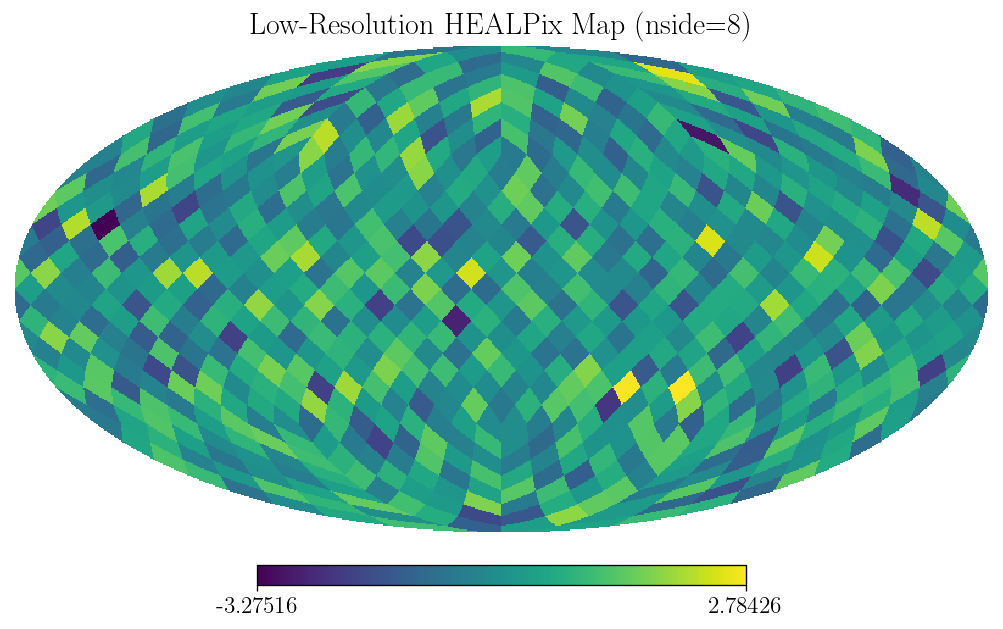

In [9]:
import numpy as np
import healpy as hp

# Define the lower resolution (low nside) for the map
low_nside = 8

# Generate a low-resolution HEALPix map
low_res_map = np.random.randn(hp.nside2npix(low_nside))

# Visualize the low-resolution map
hp.mollview(low_res_map, title='Low-Resolution HEALPix Map (nside={})'.format(low_nside))

# Show the plot
plt.show()

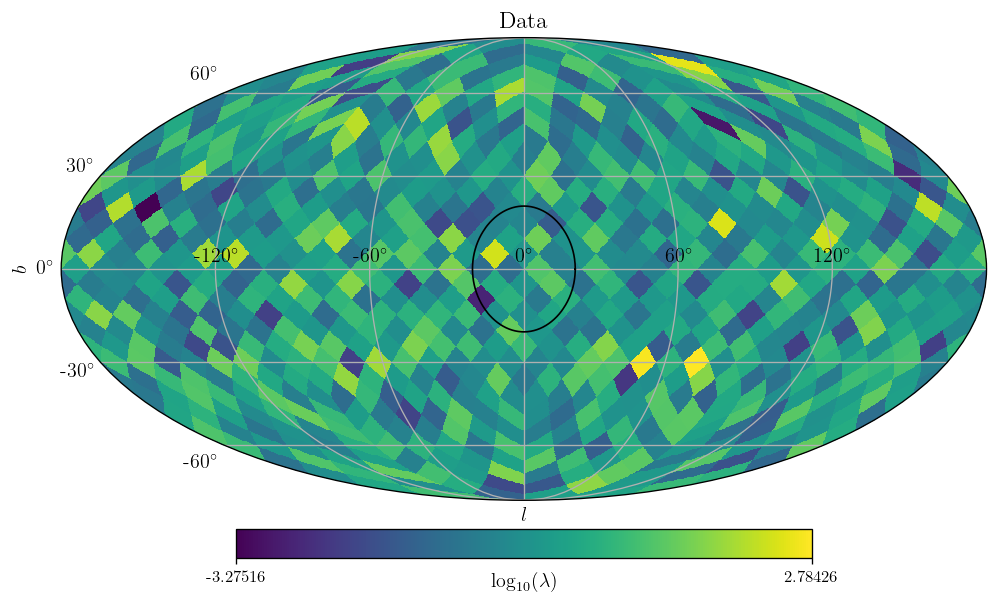

In [10]:
from healpy.newvisufunc import projview, newprojplot

# counts = ebinmodel.counts[ie]
# mask_p = np.array([False for i in range(len(counts))])
# log_counts_hp = ef.convert_masked_array_to_hp_array(counts, mask_p, log_option = True, nside=nside)

# https://healpy.readthedocs.io/en/latest/newvisufunc_example.html
pre_xtick_labels = [-120, -60, 0, 60, 120]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = [-60, -30, 0, 30, 60]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]

s = 'Data'
projview(low_res_map, coord=["C"], flip = "astro", projection_type="mollweide", title = s,
         xlabel = '$l$', ylabel = '$b$', 
         latitude_grid_spacing = 30, custom_xtick_labels=xtick_labels, custom_ytick_labels=ytick_labels,
         graticule = True, graticule_labels = True, unit='$\log_{10}(\lambda)$')

t = np.linspace(0, 2 * np.pi, 100)
l_list = 20. * np.cos(t)
b_list = 20. * np.sin(t)
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.savefig('healpix_plot.pdf')

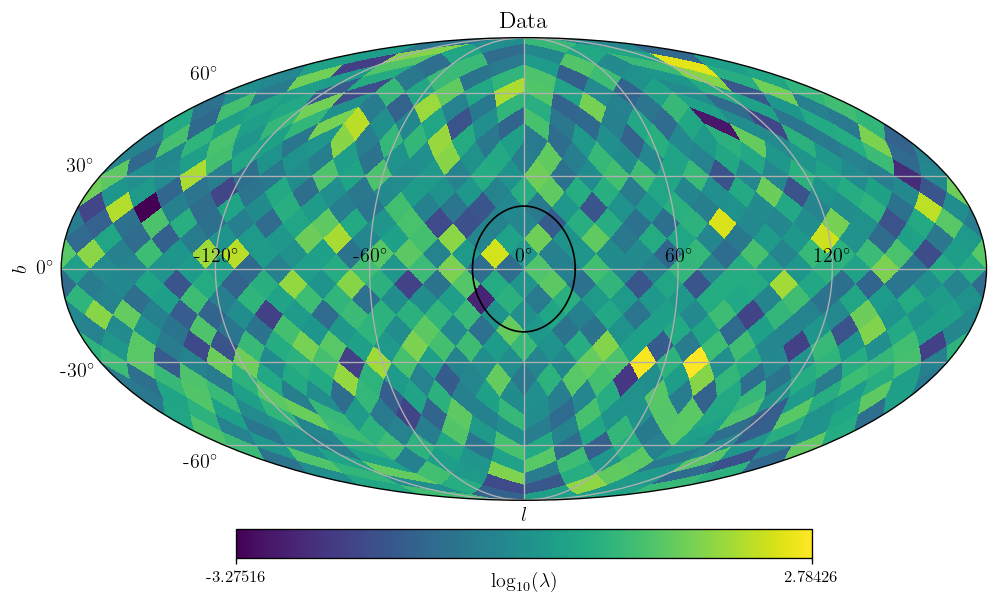

In [11]:
from healpy.newvisufunc import projview, newprojplot

# counts = ebinmodel.counts[ie]
# mask_p = np.array([False for i in range(len(counts))])
# log_counts_hp = ef.convert_masked_array_to_hp_array(counts, mask_p, log_option = True, nside=nside)

# https://healpy.readthedocs.io/en/latest/newvisufunc_example.html
pre_xtick_labels = [-120, -60, 0, 60, 120]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = [-60, -30, 0, 30, 60]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]

s = 'Data'
projview(low_res_map, coord=["C"], flip = "astro", projection_type="mollweide", title = s,
         xlabel = '$l$', ylabel = '$b$', 
         latitude_grid_spacing = 30, custom_xtick_labels=xtick_labels, custom_ytick_labels=ytick_labels,
         graticule = True, graticule_labels = True, unit='$\log_{10}(\lambda)$', 
         xsize = 4000)

t = np.linspace(0, 2 * np.pi, 100)
l_list = 20. * np.cos(t)
b_list = 20. * np.sin(t)
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.savefig('healpix_plot.pdf')

/tmp/ipykernel_2510707/3609937827.py:13: RuntimeWarning: divide by zero encountered in log10
  np.log10(counts), coord=["C"], flip = "astro", projection_type="mollweide", title = s,


<Figure size 3000x3000 with 0 Axes>

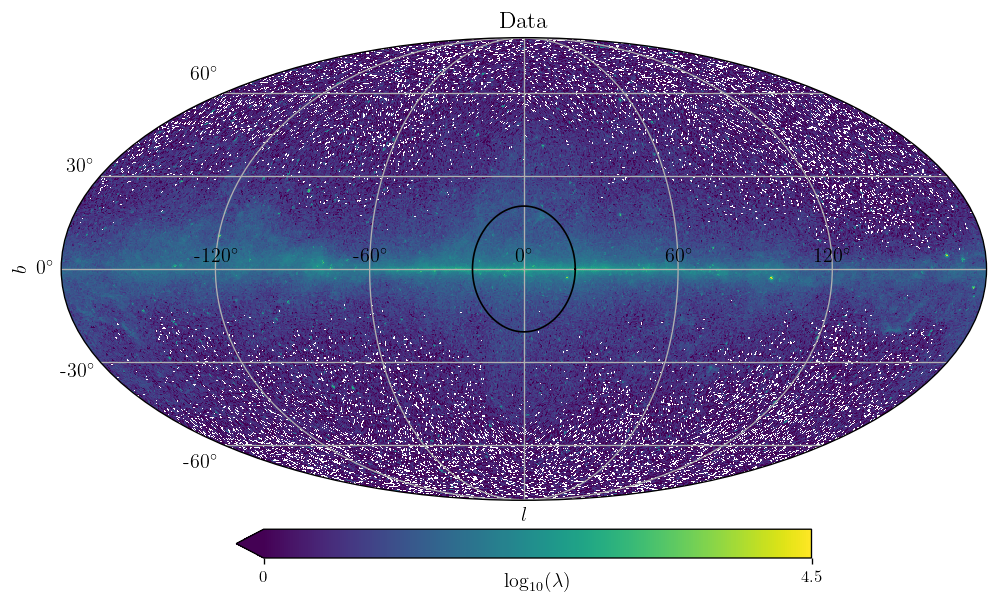

In [24]:
fig = plt.figure(figsize=(3, 3), dpi=1000)

counts = ebinmodel.counts[ie]

# https://healpy.readthedocs.io/en/latest/newvisufunc_example.html
pre_xtick_labels = [-120, -60, 0, 60, 120]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = [-60, -30, 0, 30, 60]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]

s = 'Data'
projview(
    np.log10(counts), coord=["C"], flip = "astro", projection_type="mollweide", title = s,
    xlabel = '$l$', ylabel = '$b$', 
    latitude_grid_spacing = 30, custom_xtick_labels=xtick_labels, custom_ytick_labels=ytick_labels,
    graticule = True, graticule_labels = True, unit='$\log_{10}(\lambda)$',
    xsize = 2000, min = 0, max = 4.5,
    # override_plot_properties = {'figure_width' : 8},
    )

t = np.linspace(0, 2 * np.pi, 100)
l_list = 20. * np.cos(t)
b_list = 20. * np.sin(t)
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.savefig('healpix_plot.pdf')

(-40.0, 40.0)

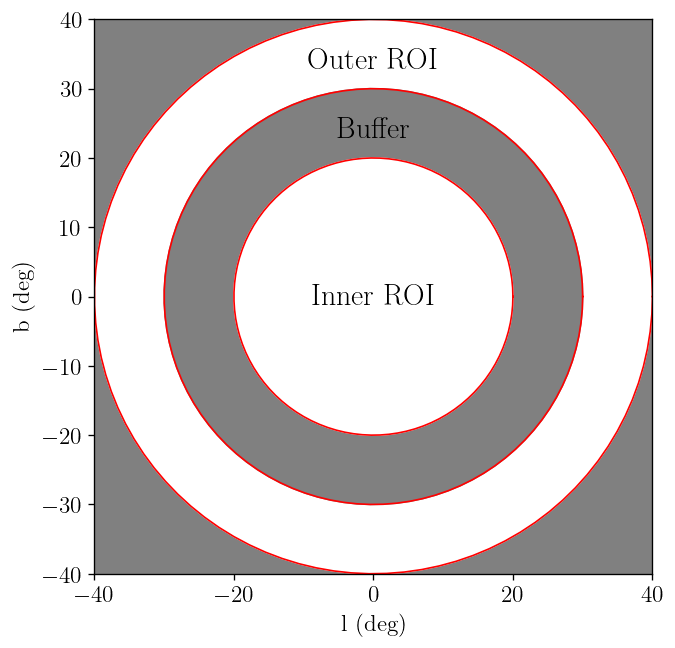

In [25]:
fig = plt.figure(figsize=(6, 6))

# plot inner roi of 20 degrees in pyplot, buffer region of 20 - 30 degrees, and outer region of 30 - 40 degrees

t = np.linspace(0, 2 * np.pi, 100)
inner_roi_x = 20. * np.cos(t)
inner_roi_y = 20. * np.sin(t)

plt.plot(inner_roi_x, inner_roi_y, color="r", ls = "-", lw = 1.)

outer_roi_low_x = 30. * np.cos(t)
outer_roi_low_y = 30. * np.sin(t)

outer_roi_high_x = 40. * np.cos(t)
outer_roi_high_y = 40. * np.sin(t)

outer_roi_lim_x = 80. * np.cos(t)
outer_roi_lim_y = 80. * np.sin(t)

plt.plot(outer_roi_low_x, outer_roi_low_y, color="r", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="r", ls = "-", lw = 1.)

# outside region fill_between gray
plt.fill(outer_roi_lim_x, outer_roi_lim_y, color = 'gray')
plt.fill(outer_roi_high_x, outer_roi_high_y, color = 'white')

# buffer as fill_between gray
plt.fill(outer_roi_low_x, outer_roi_low_y, color = 'gray')
plt.fill(inner_roi_x, inner_roi_y, color = 'white')

# inside inner_roi, add text saying "GP + Templates"
plt.text(0, 0, 'Inner ROI', horizontalalignment='center', verticalalignment='center')

# inside buffer, add text "No Fitting"
plt.text(0, 24, 'Buffer', horizontalalignment='center', verticalalignment='center')

# inside buffer, add text "No Fitting"
plt.text(0, 34, 'Outer ROI', horizontalalignment='center', verticalalignment='center')

plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.xlim([-40,40])
plt.ylim([-40,40])

In [26]:
inner_roi_x = np.deg2rad(inner_roi_x)
inner_roi_y = np.deg2rad(inner_roi_y)
outer_roi_low_x = np.deg2rad(outer_roi_low_x)
outer_roi_low_y = np.deg2rad(outer_roi_low_y)
outer_roi_high_x = np.deg2rad(outer_roi_high_x)
outer_roi_high_y = np.deg2rad(outer_roi_high_y)
outer_roi_lim_x = np.deg2rad(outer_roi_lim_x)
outer_roi_lim_y = np.deg2rad(outer_roi_lim_y)

In [27]:
from utils import create_mask as cm

inner_mask = cm.make_mask_total(
        nside=nside,
        band_mask=False,
        mask_ring=True,
        inner=0,
        outer=20.,
    )

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


['dummy$^\\circ$', '-20.0$^\\circ$', '-10.0$^\\circ$', '0.0$^\\circ$', '10.0$^\\circ$', '20.0$^\\circ$']


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(custom_xtick_labels, fontname=fontname)
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:630: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(custom_ytick_labels, fontname=fontname)


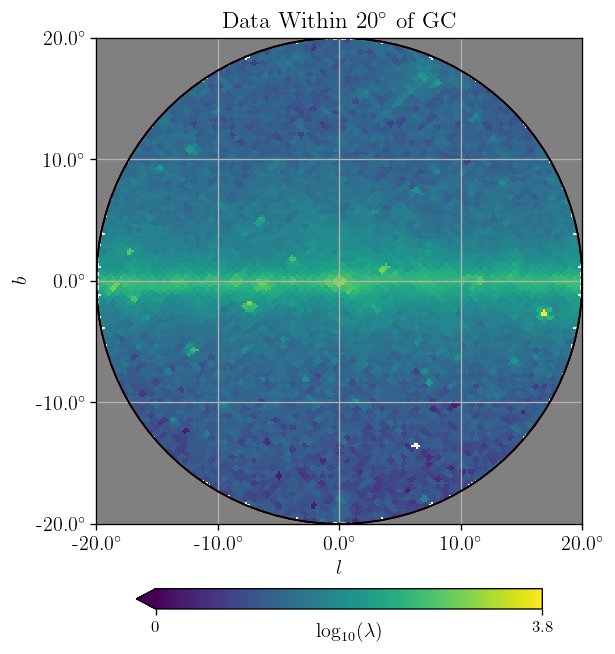

In [33]:
# fix, need to hold projview in figure

fig = plt.figure(figsize=(6, 6))

log_counts_inner_roi = ef.convert_masked_array_to_hp_array(counts[~inner_mask], inner_mask, log_option = True, nside=nside)
m = log_counts_inner_roi

s = 'Data Within 20$^{\circ}$ of GC'
pre_xtick_labels = ['dummy', -20., -10., 0., 10., 20.]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = ['dummy', -20., -10., 0., 10., 20.]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
print(xtick_labels)
projview(
    m,
    coord=["G"], 
    flip = "astro", 
    projection_type="cart", 
    title = s,
    xlabel = '$l$', 
    ylabel = '$b$', 
    xsize = 2000,
    latitude_grid_spacing = 10,
    longitude_grid_spacing = 10, 
    custom_xtick_labels=xtick_labels, 
    custom_ytick_labels=ytick_labels,
    graticule = True, 
    graticule_labels = True, 
    unit='$\log_{10}(\lambda)$',
    min = 0, max = 3.8,
    cb_orientation = 'horizontal', 
    override_plot_properties = {'cbar_pad': 0.1},
    hold = True
    )

plt.xlim(np.deg2rad(-20),np.deg2rad(20))
plt.ylim(np.deg2rad(-20),np.deg2rad(20))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

plt.xlim(np.deg2rad(-20),np.deg2rad(20))
plt.ylim(np.deg2rad(-20),np.deg2rad(20))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


['dummy$^\\circ$', '-20.0$^\\circ$', '-10.0$^\\circ$', '0.0$^\\circ$', '10.0$^\\circ$', '20.0$^\\circ$']


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(custom_xtick_labels, fontname=fontname)
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:630: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(custom_ytick_labels, fontname=fontname)


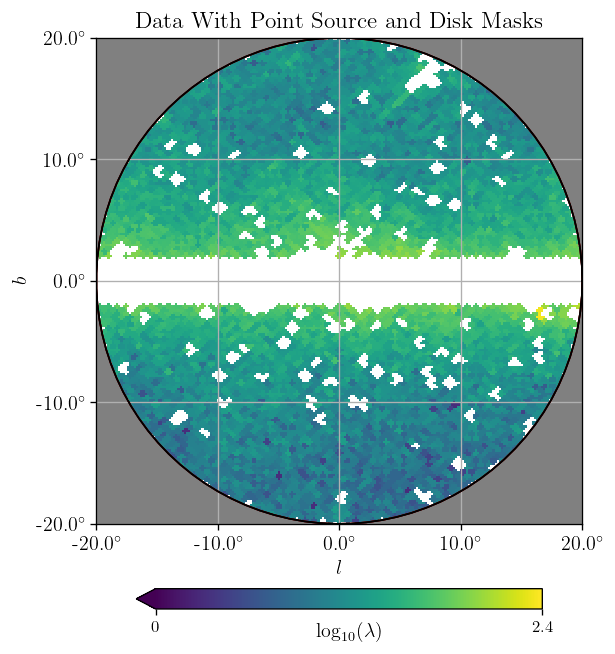

In [35]:
# fix, need to hold projview in figure

fig = plt.figure(figsize=(6, 6))

mask_p = ebinmodel.mask_roi_arr[ie]
log_counts_inner_roi_custom = ef.convert_masked_array_to_hp_array(counts[~mask_p], mask_p, log_option = True, nside=nside)
m = log_counts_inner_roi_custom

s = 'Data With Point Source and Disk Masks'
pre_xtick_labels = ['dummy', -20., -10., 0., 10., 20.]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = ['dummy', -20., -10., 0., 10., 20.]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
print(xtick_labels)
projview(
    m,
    coord=["G"], 
    flip = "astro", 
    projection_type="cart", 
    title = s,
    xlabel = '$l$', 
    ylabel = '$b$', 
    xsize = 2000,
    latitude_grid_spacing = 10,
    longitude_grid_spacing = 10, 
    custom_xtick_labels=xtick_labels, 
    custom_ytick_labels=ytick_labels,
    graticule = True, 
    graticule_labels = True, 
    unit='$\log_{10}(\lambda)$',
    min = 0, max = 2.4,
    cb_orientation = 'horizontal', 
    override_plot_properties = {'cbar_pad': 0.1},
    hold = True
    )

plt.xlim(np.deg2rad(-20),np.deg2rad(20))
plt.ylim(np.deg2rad(-20),np.deg2rad(20))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

plt.xlim(np.deg2rad(-20),np.deg2rad(20))
plt.ylim(np.deg2rad(-20),np.deg2rad(20))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

In [18]:
from utils import create_mask as cm

outer_mask = ebinmodel.outer_mask[ie]
total_mask = ~(~mask_p ^ ~outer_mask)

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


['dummy$^\\circ$', '-40.0$^\\circ$', '-20.0$^\\circ$', '0.0$^\\circ$', '20.0$^\\circ$', '40.0$^\\circ$']


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(custom_xtick_labels, fontname=fontname)
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:630: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(custom_ytick_labels, fontname=fontname)


Text(0, 0.59, '${\\rm \\bf{Outer \\ ROI}}$')

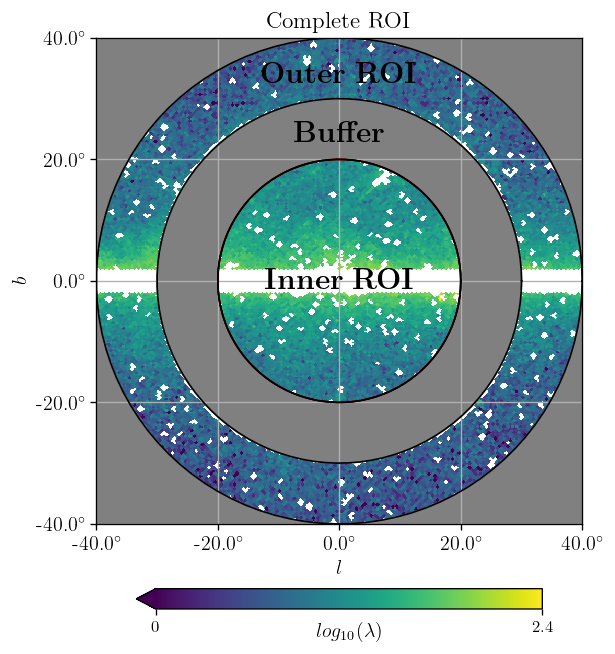

In [37]:
# fix, need to hold projview in figure

fig = plt.figure(figsize=(6, 6))

log_counts_total_roi = ef.convert_masked_array_to_hp_array(counts[~total_mask], total_mask, log_option = True, nside=nside)
m = log_counts_total_roi

s = 'Complete ROI'
pre_xtick_labels = ['dummy', -40., -20., 0., 20., 40.]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = ['dummy', -40., -20., 0., 20., 40.]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
print(xtick_labels)
projview(
    m,
    coord=["G"], 
    flip = "astro", 
    projection_type="cart", 
    title = s,
    xlabel = '$l$', 
    ylabel = '$b$', 
    xsize = 2000,
    latitude_grid_spacing = 20,
    longitude_grid_spacing = 20, 
    custom_xtick_labels=xtick_labels, 
    custom_ytick_labels=ytick_labels,
    graticule = True, 
    graticule_labels = True, 
    unit='$log_{10}(\lambda)$',
    min = 0, max = 2.4,
    cb_orientation = 'horizontal', 
    override_plot_properties = {'cbar_pad': 0.1},
    hold = True
    )

plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

annulus_roi_x = [outer_roi_high_x, outer_roi_lim_x[::-1]]
annulus_roi_y = [outer_roi_high_y, outer_roi_lim_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

# inside inner_roi, add text saying "GP + Templates"
plt.text(0, 0, '${\\rm \\bf{Inner \\ ROI}}$', horizontalalignment='center', verticalalignment='center', weight = 'bold')

# inside buffer, add text "No Fitting"
plt.text(0, 0.42, '${\\rm \\bf{Buffer}}$', horizontalalignment='center', verticalalignment='center', weight = 'bold')

# inside buffer, add text "No Fitting"
plt.text(0, 0.59, '${\\rm \\bf{Outer \\ ROI}}$', horizontalalignment='center', verticalalignment='center', color = 'black')

/tmp/ipykernel_2510707/3749470050.py:6: RuntimeWarning: divide by zero encountered in log10
  m = np.squeeze(np.log10(counts))


['dummy$^\\circ$', '-40.0$^\\circ$', '-20.0$^\\circ$', '0.0$^\\circ$', '20.0$^\\circ$', '40.0$^\\circ$']


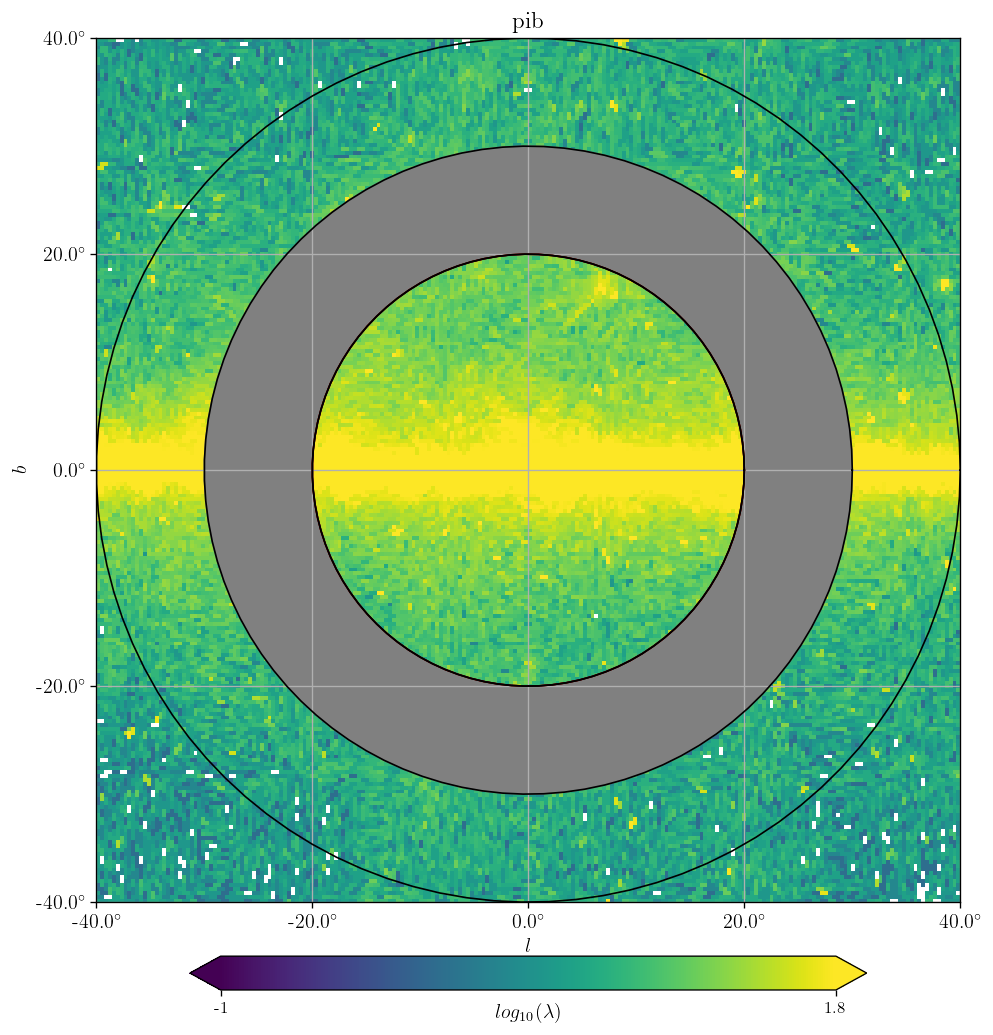

In [20]:
# fix, need to hold projview in figure

fig = plt.figure(figsize=(10, 10))

s = 'pib' # name of template
m = np.squeeze(np.log10(counts))

pre_xtick_labels = ['dummy', -40., -20., 0., 20., 40.]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = ['dummy', -40., -20., 0., 20., 40.]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
print(xtick_labels)
projview(
    m,
    coord=["G"], 
    flip = "astro", 
    projection_type="cart", 
    title = s,
    xlabel = '$l$', 
    ylabel = '$b$', 
    xsize = 1000,
    latitude_grid_spacing = 20,
    longitude_grid_spacing = 20, 
    custom_xtick_labels=xtick_labels, 
    custom_ytick_labels=ytick_labels,
    graticule = True, 
    graticule_labels = True, 
    unit='$log_{10}(\lambda)$',
    min = -1, max = 1.8,
    cb_orientation = 'horizontal', 
    hold = True
    )

plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

/tmp/ipykernel_2510707/1827530984.py:5: RuntimeWarning: divide by zero encountered in log10
  m = np.log10(counts)


['dummy$^\\circ$', '-40.0$^\\circ$', '-20.0$^\\circ$', '0.0$^\\circ$', '20.0$^\\circ$', '40.0$^\\circ$']


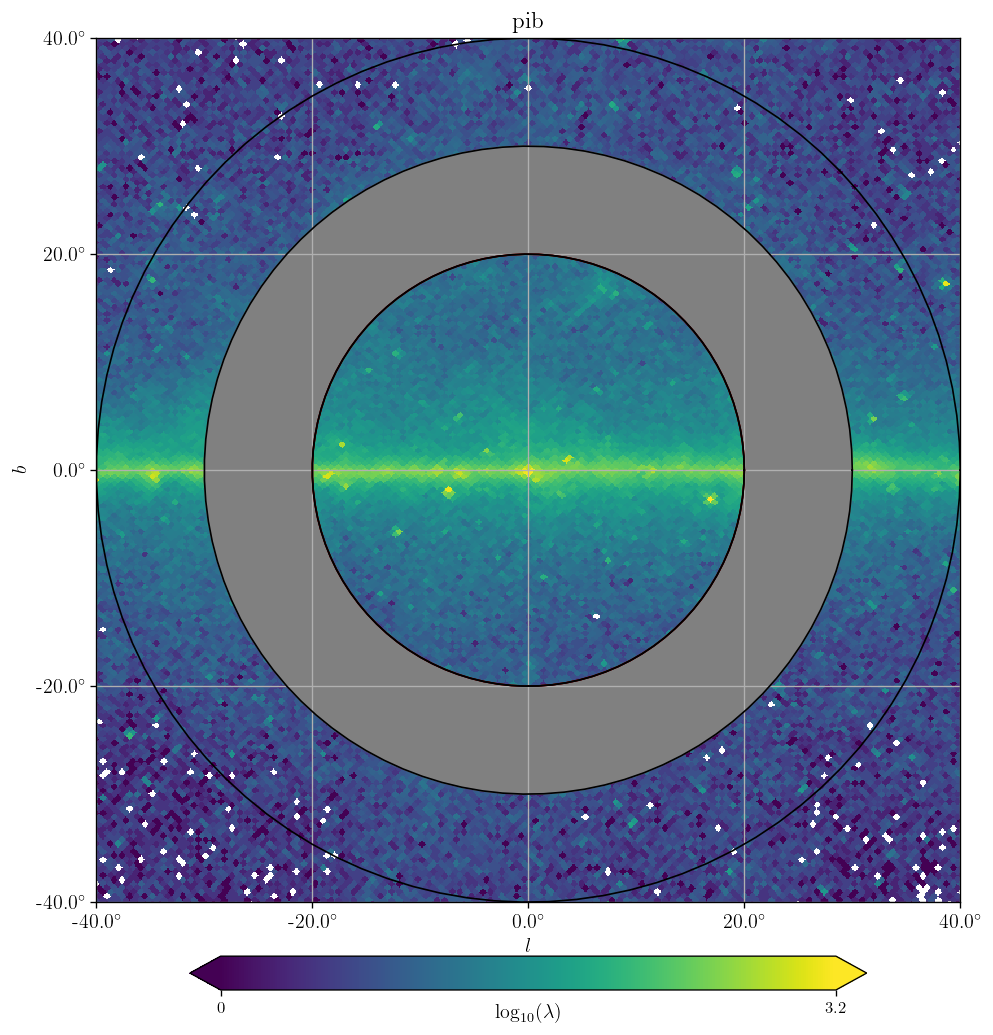

In [21]:
# fix, need to hold projview in figure

fig = plt.figure(figsize=(10, 10))

m = np.log10(counts)

pre_xtick_labels = ['dummy', -40., -20., 0., 20., 40.]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = ['dummy', -40., -20., 0., 20., 40.]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
print(xtick_labels)
projview(
    m,
    coord=["G"], 
    flip = "astro", 
    projection_type="cart", 
    title = s,
    xlabel = '$l$', 
    ylabel = '$b$', 
    xsize = 3000,
    latitude_grid_spacing = 20,
    longitude_grid_spacing = 20, 
    custom_xtick_labels=xtick_labels, 
    custom_ytick_labels=ytick_labels,
    graticule = True, 
    graticule_labels = True, 
    unit='$\log_{10}(\lambda)$',
    min = 0, max = 3.2,
    cb_orientation = 'horizontal', 
    hold = True
    )

plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

LaTeX Table of Parameter Means
Generate Table with OverLeaf using Output Below:

\begin{table}[htb]
\centering
\begin{tabular}{|c|c|}
\hline
Quantity & Value \\
\hline
S_{blg} & 0.337 \\
S_{bub} & 1.055 \\
S_{ics} & 6.005 \\
S_{iso} & 0.312 \\
S_{nfw} & 2.114 \\
S_{pib} & 11.399 \\
S_{psc} & 0.062 \\
\hline
\end{tabular}
\end{table}


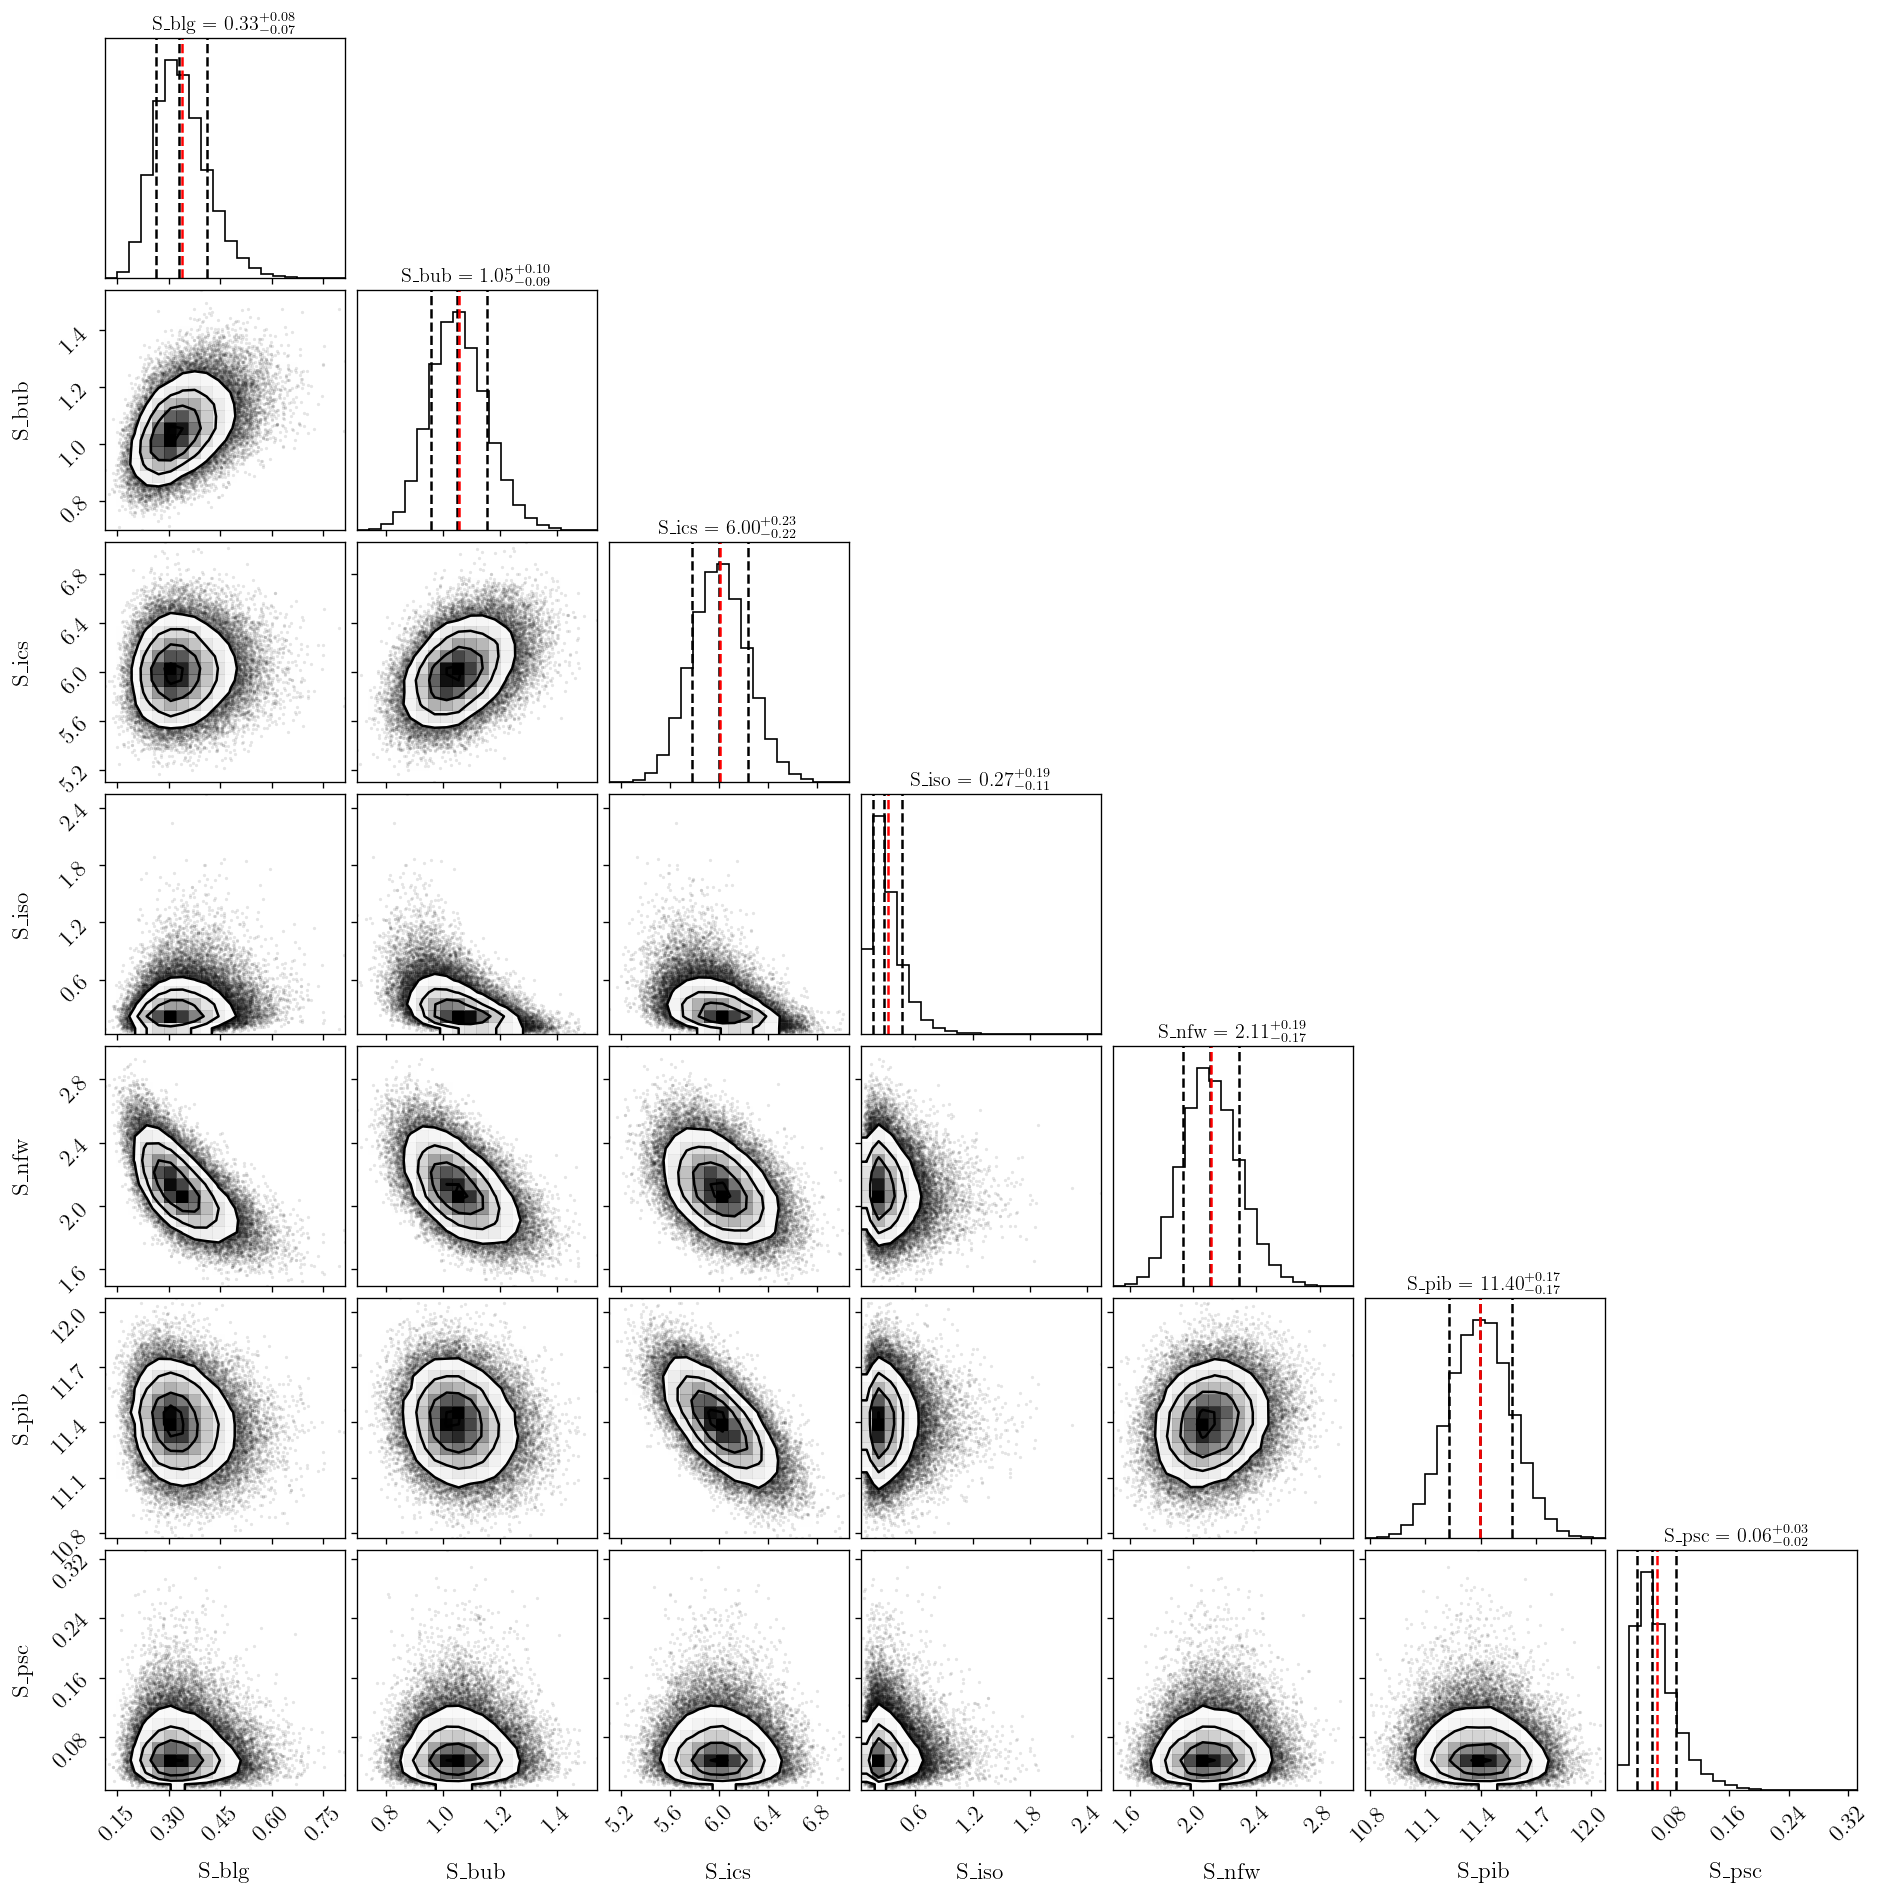

In [6]:
# simulated data will consist of mean normalizations from fit

S_blg = np.mean(samples['S_blg'])
S_bub = np.mean(samples['S_bub'])
S_psc = np.mean(samples['S_psc'])
S_iso = np.mean(samples['S_iso'])
S_nfw = np.mean(samples['S_nfw'])
S_pib = np.mean(samples['S_pib'])
S_ics = np.mean(samples['S_ics'])
if nfw_gamma == 'vary':
    gamma = np.mean(samples['gamma'])
else:
    gamma = nfw_gamma

# corner plot and latex table of means

fig = ef.make_corner_plots(samples, with_mean_vlines = True, print_latex_means = True)